In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle(1).json to kaggle(1).json


In [ ]:
import os
os.listdir("/content")


['.config', 'kaggle(1).json', 'sample_data']

In [ ]:
!mkdir -p ~/.kaggle
!cp "kaggle(1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d atikaakter11/brain-tumor-segmentation-dataset


Dataset URL: https://www.kaggle.com/datasets/atikaakter11/brain-tumor-segmentation-dataset
License(s): MIT
  0% 0.00/106M [00:00<?, ?B/s]
100% 106M/106M [00:00<00:00, 1.50GB/s]


In [ ]:
!unzip brain-tumor-segmentation-dataset.zip -d data


Streaming output truncated to the last 5000 lines.
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0315.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0316.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0317.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0320.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0321.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0322.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0324.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0325.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0326.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0327.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0332.jpg  
  inflating: data/Brain Tumor Segmentation Dataset/image/3/Tr-pi_0334.jpg  
  inflating: data/Brain Tumor Segment

In [ ]:
import os
os.listdir("data")


['Brain Tumor Segmentation Dataset']

In [ ]:
import os

base_path = "data/Brain Tumor Segmentation Dataset"

os.listdir(base_path)


['mask', 'image']

In [ ]:
image_path = os.path.join(base_path, "image")
mask_path = os.path.join(base_path, "mask")


In [123]:
import os

def get_all_files(folder):
    """
    Recursively get all files in subfolders of a folder.
    Returns a list of full file paths.
    """
    files_list = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.png', '.jpg')):
                files_list.append(os.path.join(root, file))
    return sorted(files_list)  # sort for consistency

image_folder = '/content/data/Brain Tumor Segmentation Dataset/image/'
mask_folder = '/content/data/Brain Tumor Segmentation Dataset/mask/'
output_folder = '/content/segmented/'

os.makedirs(output_folder, exist_ok=True)

# Get all image and mask paths
image_files = get_all_files(image_folder)
mask_files = get_all_files(mask_folder)

print(f"Total images: {len(image_files)}")
print(f"Total masks: {len(mask_files)}")



Total images: 4237
Total masks: 4239


In [122]:
import os
import cv2
import numpy as np

# Dataset paths
dataset_path = '/content/data/Brain Tumor Segmentation Dataset/'
image_folder = os.path.join(dataset_path, 'image')
mask_folder = os.path.join(dataset_path, 'mask')
output_folder = '/content/segmented/'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)


In [97]:
class_ids = ['0', '1', '2', '3']  # 0=No Tumor, 1=Glioma, 2=Meningioma, 3=Pituitary

image_files = []
mask_files = []

for cls in class_ids:
    img_cls_folder = os.path.join(image_folder, cls)
    mask_cls_folder = os.path.join(mask_folder, cls)

    # List files and sort to match order
    img_files = sorted([os.path.join(img_cls_folder, f) for f in os.listdir(img_cls_folder) if f.endswith(('.png', '.jpg'))])
    mask_files_cls = sorted([os.path.join(mask_cls_folder, f) for f in os.listdir(mask_cls_folder) if f.endswith(('.png', '.jpg'))])

    # Take only same number of masks as images
    if len(mask_files_cls) > len(img_files):
        mask_files_cls = mask_files_cls[:len(img_files)]

    image_files.extend(img_files)
    mask_files.extend(mask_files_cls)

print(f"Total images collected: {len(image_files)}")
print(f"Total masks collected: {len(mask_files)}")


Total images collected: 4237
Total masks collected: 4237


In [113]:
classes = [0, 1, 2, 3]  # 0=No Tumor, 1=Glioma, 2=Meningioma, 3=Pituitary

# Otsu Thresholding on grayscale MRI
def otsu_segmentation_from_image(img):
    # Apply Otsu to the whole image
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

# Adaptive Thresholding on grayscale MRI
def adaptive_segmentation_from_image(img):
    thresh = cv2.adaptiveThreshold(img, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    return thresh

# Multi-class segmentation from MRI image
def multi_class_segmentation(img, method='otsu'):

    segmented = np.zeros_like(img, dtype=np.uint8)

    if method == 'otsu':
        thresh_img = otsu_segmentation_from_image(img)
    else:
        thresh_img = adaptive_segmentation_from_image(img)

    # Example mapping: assign intensity ranges to classes
    # You can adjust these thresholds based on your MRI intensity histogram
    segmented[(thresh_img > 50) & (thresh_img <= 100)] = 1  # Glioma
    segmented[(thresh_img > 100) & (thresh_img <= 150)] = 2 # Meningioma
    segmented[thresh_img > 150] = 3                          # Pituitary
    # 0 remains background

    return segmented


In [121]:
# Dice coefficient per class
def dice_coefficient(y_true, y_pred, class_id):
    y_true_c = (y_true == class_id).astype(np.uint8)
    y_pred_c = (y_pred == class_id).astype(np.uint8)
    intersection = np.sum(y_true_c * y_pred_c)
    total = np.sum(y_true_c) + np.sum(y_pred_c)
    return 1.0 if total==0 else 2*intersection/total

# Mean Dice over all tumor classes
def mean_dice(y_true, y_pred):
    return np.mean([dice_coefficient(y_true, y_pred, c) for c in classes[1:]])

# Mean Jaccard (IoU) over all tumor classes
def jaccard_score(y_true, y_pred):
    jaccards = []
    for c in classes[1:]:
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        intersection = np.sum(y_true_c * y_pred_c)
        union = np.sum(y_true_c) + np.sum(y_pred_c) - intersection
        jaccards.append(1.0 if union==0 else intersection/union)
    return np.mean(jaccards)

In [119]:
otsu_dice_list = []
adaptive_dice_list = []
otsu_jaccard_list = []
adaptive_jaccard_list = []

for img_path, mask_path in zip(image_files, mask_files):
    img = cv2.imread(img_path, 0)   # MRI image
    mask = cv2.imread(mask_path, 0) # Ground truth mask

    # Resize mask to match image
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # -------- Otsu segmentation --------
    seg_otsu = multi_class_segmentation(img, method='otsu')
    otsu_dice_list.append(mean_dice(mask, seg_otsu))
    otsu_jaccard_list.append(jaccard_score(mask, seg_otsu))

    # -------- Adaptive segmentation --------
    seg_adaptive = multi_class_segmentation(img, method='adaptive')
    adaptive_dice_list.append(mean_dice(mask, seg_adaptive))
    adaptive_jaccard_list.append(jaccard_score(mask, seg_adaptive))

    # Save segmented images
    base_name = os.path.basename(img_path)
    cv2.imwrite(os.path.join(output_folder, f"otsu_{base_name}"), seg_otsu)
    cv2.imwrite(os.path.join(output_folder, f"adaptive_{base_name}"), seg_adaptive)

# Print final metrics
print(f"Mean Dice (Otsu on MRI): {np.mean(otsu_dice_list):.4f}")
print(f"Mean Jaccard (Otsu on MRI): {np.mean(otsu_jaccard_list):.4f}")
print(f"Mean Dice (Adaptive on MRI): {np.mean(adaptive_dice_list):.4f}")
print(f"Mean Jaccard (Adaptive on MRI): {np.mean(adaptive_jaccard_list):.4f}")

Mean Dice (Otsu on MRI): 0.2512
Mean Jaccard (Otsu on MRI): 0.2511
Mean Dice (Adaptive on MRI): 0.2510
Mean Jaccard (Adaptive on MRI): 0.2510


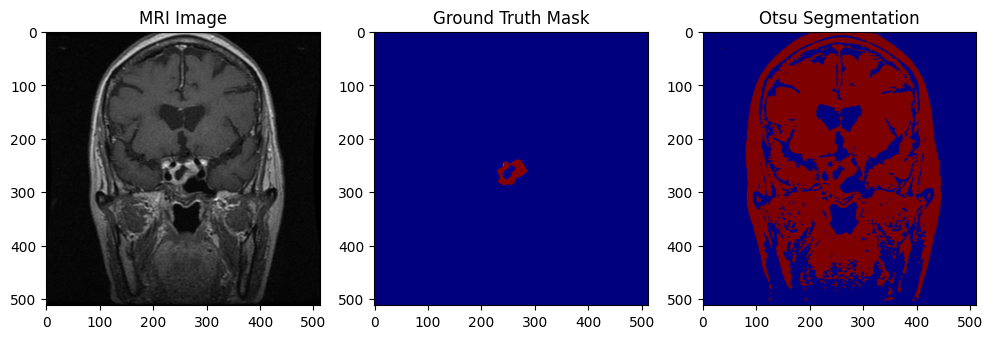

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("MRI Image")
plt.imshow(img, cmap='gray')
plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap='jet')
plt.subplot(1,3,3)
plt.title("Otsu Segmentation")
plt.imshow(seg_otsu, cmap='jet')
plt.show()
